# 0.2 Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
# Print first 5 samples of our dataset
for data, label in zip(X[:5], y[:5]):
    print(f"data: {data}, label: {label}")

data: [0.75424625 0.23148074], label: 1
data: [-0.75615888  0.15325888], label: 1
data: [-0.81539193  0.17328203], label: 1
data: [-0.39373073  0.69288277], label: 1
data: [ 0.44220765 -0.89672343], label: 0


In [4]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

print(circles.head())

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0


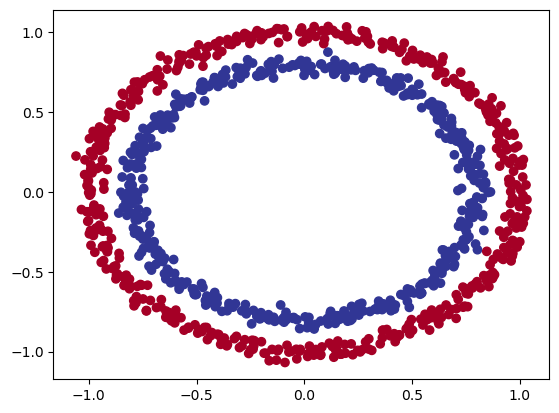

In [5]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape}, and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,), and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Print first 5 samples of our dataset
for data, label in zip(X[:5], y[:5]):
    print(f"data: {data}, label: {label}")

data: tensor([0.7542, 0.2315]), label: 1.0
data: tensor([-0.7562,  0.1533]), label: 1.0
data: tensor([-0.8154,  0.1733]), label: 1.0
data: tensor([-0.3937,  0.6929]), label: 1.0
data: tensor([ 0.4422, -0.8967]), label: 0.0


In [10]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [11]:
# Split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [13]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
# Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # Define forward method() that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    
# Instantiate an instance of our model class and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# Let's replicate model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0745, -0.0629],
                      [-0.0246, -0.4260],
                      [-0.0580,  0.1303],
                      [-0.1347, -0.2706],
                      [-0.5286, -0.3828]])),
             ('0.bias', tensor([-0.3826, -0.6835, -0.5545,  0.5383,  0.2538])),
             ('1.weight',
              tensor([[ 0.3326,  0.0535, -0.1620,  0.0865, -0.3609]])),
             ('1.bias', tensor([0.1481]))])

In [17]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions :\n{torch.round(untrained_preds)[:10]}")
print(f"\nFirst 10 labels :\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions :
tensor([[-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.]])

First 10 labels :
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

In [18]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in (withLogitsLoss)

# same as above
# loss_fn = nn.Sequential(
#             nn.Sigmoid(),
#             nn.BCELoss()
#         )

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [19]:
# Calculate accuracy - out of hundred examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model
To train our model, we are going to need to build a training loop with the follawing steps:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs will be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multi class classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [20]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():    
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0163],
        [ 0.0803],
        [-0.1356],
        [ 0.0169],
        [ 0.0772]])

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [22]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4959],
        [0.5201],
        [0.4662],
        [0.5042],
        [0.5193]])

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5,  `y=0` (class 0)

In [23]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


### 3.2 Building a training loop and testing loop

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss / accuracy
    loss = loss_fn(y_logits,
                   y_train)
    
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss / acc
        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69490, Acc: 51.00% | Test loss: 0.69894, Test acc: 48.00%
Epoch: 10 | Loss: 0.69466, Acc: 51.00% | Test loss: 0.69847, Test acc: 49.00%
Epoch: 20 | Loss: 0.69448, Acc: 51.12% | Test loss: 0.69807, Test acc: 49.00%
Epoch: 30 | Loss: 0.69434, Acc: 51.38% | Test loss: 0.69773, Test acc: 48.50%
Epoch: 40 | Loss: 0.69421, Acc: 51.25% | Test loss: 0.69743, Test acc: 48.50%
Epoch: 50 | Loss: 0.69410, Acc: 51.12% | Test loss: 0.69717, Test acc: 49.00%
Epoch: 60 | Loss: 0.69400, Acc: 51.00% | Test loss: 0.69693, Test acc: 49.00%
Epoch: 70 | Loss: 0.69391, Acc: 51.00% | Test loss: 0.69672, Test acc: 49.00%
Epoch: 80 | Loss: 0.69384, Acc: 50.88% | Test loss: 0.69653, Test acc: 49.00%
Epoch: 90 | Loss: 0.69377, Acc: 50.88% | Test loss: 0.69636, Test acc: 49.00%


# 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

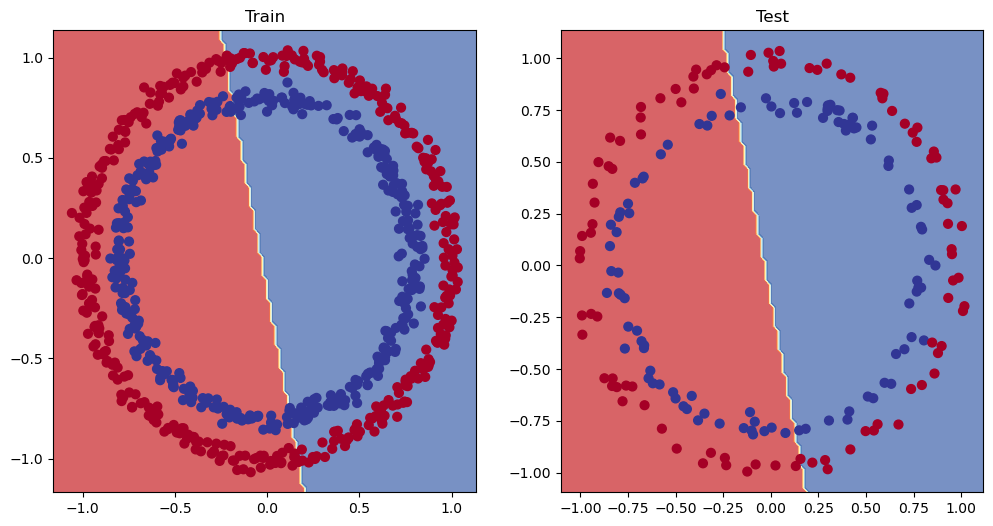

In [29]:
from helper_functions import plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)